#### On cherche à garder les meilleures variables pour notre modèle de classification :
**Voici les objectifs du notebook**
- On va donc utiliser les **features importances** de randomforest et puis ne l'entraîner que sur les meilleures features pour que le modèle ne soit pas trop lourd
- **Voir si les données de l'open data(température) est utile pour l'entraînement sur les étiquettes DPE**
- Modifier les paramètres du model pour un bon compromis taille/performance
- Evaluer avec l'accuracy mais aussi le **F1-score et la courbe ROC car l'étiquette DPE est déséquilibrer**
- Stratifier notre train/test split
- Utilisation de **SMOTE** et comparaison 
- Exporter le modèle


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pickle
from pre_processing import preprocess_data, import_data
import numpy as np
import matplotlib.pyplot as plt


In [15]:
df = import_data('data/dataset_M2_enedis.csv')
print(df.shape)
# Entrée ayant la date réception la plus petite et la plus grande

print(df['Date_réception_DPE'].min())
print(df['Date_réception_DPE'].max())
print(df['Date_réception_DPE'])


Import réussi
(10000, 136)
2021-07-01
2024-09-16
0       2023-01-27
1       2023-03-17
2       2022-07-01
3       2022-02-03
4       2022-08-02
           ...    
9995    2022-11-11
9996    2024-07-25
9997    2023-12-31
9998    2021-10-27
9999    2023-10-07
Name: Date_réception_DPE, Length: 10000, dtype: object


d:\M2\Python\Projet\pre_processing.py:15: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(chemin, sep=';')


In [16]:
df = preprocess_data(df, sauvegarde=False)

Prétraitement des données...
Removing missing values...
Encodage des variables catégorielles...
Gestion des outliers...
Gestion des valeurs manquantes...


#### Proportion des étiquettes :


In [17]:
df["Etiquette_DPE"].value_counts()
# On voit que les classes sont déséquilibrées, on va donc faire un oversampling pour équilibrer les classes et stratifier le train_test_split

2    3790
3    2954
4    1752
5     563
1     381
6     376
0     184
Name: Etiquette_DPE, dtype: int64

In [18]:
from imblearn.over_sampling import SMOTE

df.head()
print(df.info()) # Voir le type des colonnes : ne devrait avoir que des float64 car Encoding des variables catégorielles
# Définition des variables explicatives et de la variable cible
target = "Etiquette_DPE"
X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution of the resampled target
print(y_train_resampled.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Columns: 107 entries, Unnamed: 0 to id
dtypes: float64(72), int32(35)
memory usage: 6.9 MB
None
3    2653
4    2653
2    2653
0    2653
5    2653
1    2653
6    2653
Name: Etiquette_DPE, dtype: int64


#### Entraînement du Modèle

In [19]:
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)
print("Entrainement du modèle...")
RF_model.fit(X_train_resampled, y_train_resampled)
y_pred = RF_model.predict(X_test)


Entrainement du modèle...


Résultats du modèle...
Accuracy: 0.9703333333333334
F1-Score: 0.9703425285076429
Meilleures features...
1. Conso_5_usages_par_m²_é_primaire: 0.17042323575155566
2. Emission_GES_5_usages_par_m²: 0.09864658959903763
3. Conso_5_usages/m²_é_finale: 0.08729402349464606
4. Etiquette_GES: 0.06354633921949722
5. Coût_éclairage: 0.02149078256446136
Si on doit réduire la dimensions, il ne faudra garde que les 5 features ci-dessus


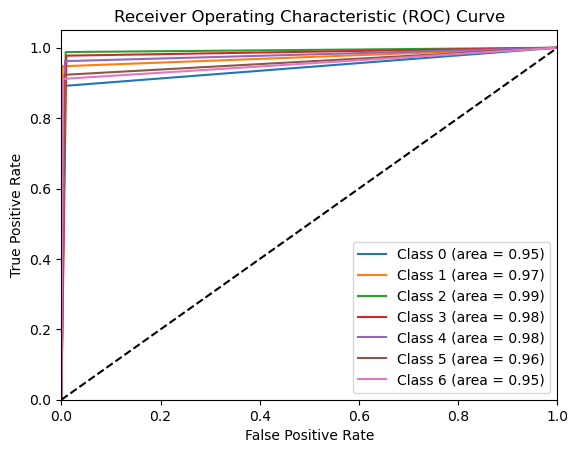

In [20]:
from sklearn.metrics import roc_curve, auc, f1_score
import numpy as np

def display_model_results(model, X, y_test, y_pred, top_n=5):
  print("Résultats du modèle...")
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='weighted')
  print(f"Accuracy: {accuracy}")
  print(f"F1-Score: {f1}")
  print("Meilleures features...")
  feature_importances = model.feature_importances_
  indices = np.argsort(feature_importances)[::-1]
  top_features = X.columns[indices[:top_n]]
  top_importances = feature_importances[indices[:top_n]]
  for i, feature in enumerate(top_features):
    print(f"{i+1}. {feature}: {top_importances[i]}")
  print(f"Si on doit réduire la dimensions, il ne faudra garde que les {top_n} features ci-dessus")
  return top_features


def plot_roc_curve(y_test, y_pred, n_classes):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure()
  for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.show()

n_classes = len(np.unique(y_test))
top_features = display_model_results(RF_model, X, y_test, y_pred, top_n=5)
# print(top_features)
plot_roc_curve(y_test, y_pred, n_classes)


- **F1 et accuracy très haute**
- **Bonne courbe ROC**
- **Température ne fait pas partie des variables utiles, cohérent car énormément de missing values.**

**Essayons de réentraîner le modèle avec ces 10 features et regardons si l'accuracy à changer**

Entrainement du modèle...
Résultats du modèle...
Résultats du modèle...
Accuracy: 0.985
F1-Score: 0.9850243430657486
Meilleures features...
1. Conso_5_usages_par_m²_é_primaire: 0.47009573235313523
2. Conso_5_usages/m²_é_finale: 0.16641210251581667
3. Emission_GES_5_usages_par_m²: 0.16608359467162742
4. Etiquette_GES: 0.14851174217555085
5. Coût_éclairage: 0.048896828283869834
Si on doit réduire la dimensions, il ne faudra garde que les 5 features ci-dessus


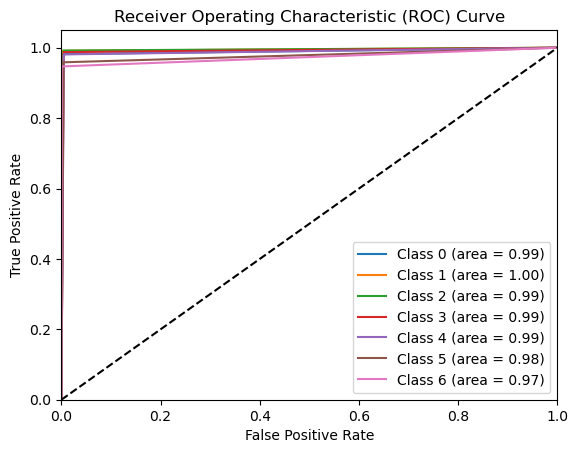

In [21]:
RF_model_alleger = RandomForestClassifier(n_estimators=100, random_state=42)
print("Entrainement du modèle...")
X_train, X_test = X_train[top_features], X_test[top_features]
RF_model_alleger.fit(X_train, y_train)
y_pred = RF_model_alleger.predict(X_test)

print("Résultats du modèle...")
display_model_results(RF_model_alleger, X[top_features], y_test, y_pred, top_n=5)
plot_roc_curve(y_test, y_pred, n_classes)


**On voit que le modèle garde une accuracy très élevé (99%), même en ne retenant que les 10 premières variables, essayons avec 5**

-> Nous avons 0.987, on va donc garder un modèle avec les 5 meilleures features, essayons aussi de baisser le nombre d'estimator


Entrainement du modèle...
Résultats du modèle...
Résultats du modèle...
Accuracy: 0.9826666666666667
F1-Score: 0.9827108740620979
Meilleures features...
1. Conso_5_usages_par_m²_é_primaire: 0.5080513516894986
2. Conso_5_usages/m²_é_finale: 0.16369481235944608
3. Etiquette_GES: 0.1410032956660115
4. Emission_GES_5_usages_par_m²: 0.14077492980600773
5. Coût_éclairage: 0.046475610479036256
Si on doit réduire la dimensions, il ne faudra garde que les 5 features ci-dessus


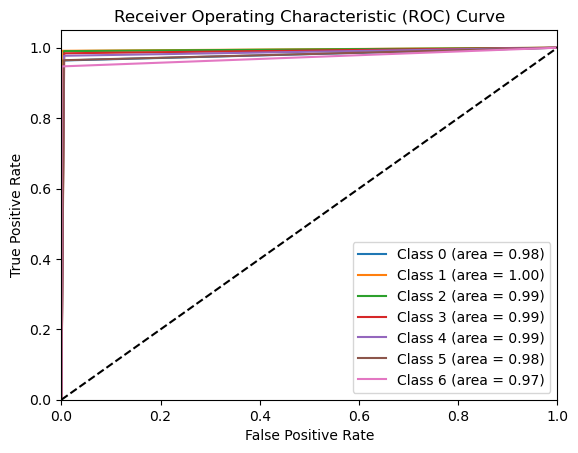

In [22]:
RF_model_alleger = RandomForestClassifier(n_estimators=10, random_state=42)
print("Entrainement du modèle...")
X_train, X_test = X_train[top_features], X_test[top_features]
RF_model_alleger.fit(X_train, y_train)
y_pred = RF_model_alleger.predict(X_test)

print("Résultats du modèle...")
display_model_results(RF_model_alleger, X[top_features], y_test, y_pred, top_n=5)
plot_roc_curve(y_test, y_pred, n_classes)


**Lorsqu'on passe de 100 à 10 estimator, l'accuracy ne change pas, on va donc en garder que 10**

### Export du modèle

In [23]:

try:
  with open('RF_alleger_Classification_Etiquette.pkl', 'wb') as file:
      pickle.dump(RF_model_alleger, file)
  print(f"Modèle sauvegardé avec succès sous : {'RF_alleger_Classification_Etiquette.pkl'}")
except Exception as e:
  print(f"Erreur lors de la sauvegarde du modèle : {e}")

Modèle sauvegardé avec succès sous : RF_alleger_Classification_Etiquette.pkl


In [24]:
list(top_features)

['Conso_5_usages_par_m²_é_primaire',
 'Emission_GES_5_usages_par_m²',
 'Conso_5_usages/m²_é_finale',
 'Etiquette_GES',
 'Coût_éclairage']